# Aug images with Bbox

In [1]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import os
from itertools import combinations
from tqdm.notebook import tqdm

## Show aug with Bbox

In [2]:
# Convert bbox from yolo format to coco format
def yolo_to_coco(image_width, image_height, x_center, y_center, width, height):
    
    abs_x_center = x_center * image_width
    abs_y_center = y_center * image_height
    abs_width = width * image_width
    abs_height = height * image_height

    x_min = abs_x_center - (abs_width / 2)
    y_min = abs_y_center - (abs_height / 2)

    return [x_min, y_min, abs_width, abs_height]

# Draw bbox and label on image
CLASSES = {'0': 'Sand 0-20 mm', '1': 'Sand 0-5 mm', '2': 'Rubble 5-20 mm', '3': 'Rubble 8-16 mm', '4': 'Rubble 20-25 mm', 
           '5': 'Rubble 20-30 mm', '6': 'Rubble 20-30 mm', '7': 'Rubble 20-40 mm', '8': 'Rubble 25-60 mm', '9': 'Rubble 40-70 mm', '10': 'Rubble 0-300 mm'}

def draw_bbox_and_label(image, bbox, class_label, h, w):
    # draw bbox
    cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3])), (255,0,0), 2)

    # draw label
    tl = round(0.002 * (h + w) / 2) + 1
    tf = max(tl - 1, 1)
    class_name = CLASSES[class_label]
    c1, c2 = (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3]))
    t_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, tl/3, tf)[0]
    c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    cv2.rectangle(image, c1, c2, (255,0,0), -1, cv2.LINE_AA)
    cv2.putText(image, class_name, (c1[0], c1[1] - 2), 0, tl / 3,
                [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return image

# Get image with bbox and label
def process_image(image, class_boxes, class_labels):
    h, w, _ = image.shape
    coco_boxes = [yolo_to_coco(w, h, bbox[0], bbox[1], bbox[2], bbox[3]) for bbox in class_boxes]
    for bbox, class_label in zip(coco_boxes, class_labels):
        image = draw_bbox_and_label(image, bbox, class_label, h, w)
    return image

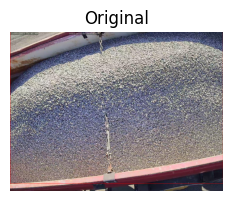

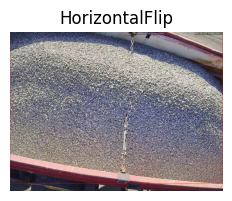

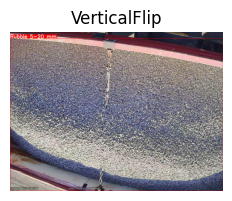

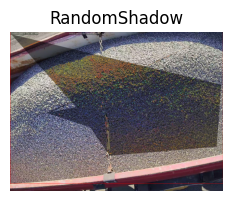

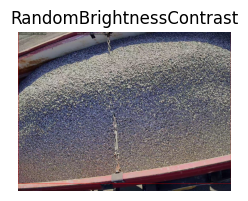

In [11]:
# Show augmented images
selected_image = 1

transforms = [A.Compose([A.HorizontalFlip(p=1)], bbox_params=A.BboxParams(format='yolo', min_visibility=0.1, label_fields=['class_labels'])),
              A.Compose([A.VerticalFlip(p=1)], bbox_params=A.BboxParams(format='yolo', min_visibility=0.1, label_fields=['class_labels'])),
              A.Compose([A.MedianBlur(p=1, blur_limit=5)], bbox_params=A.BboxParams(format='yolo', min_visibility=0.1, label_fields=['class_labels'])),
              A.Compose([A.RandomBrightnessContrast(brightness_limit=(-0.15, 0.15), contrast_limit=0.1, p=1)], bbox_params=A.BboxParams(format='yolo', min_visibility=0.1, label_fields=['class_labels']))]

transform_names = ["HorizontalFlip", "VerticalFlip", "RandomShadow", "RandomBrightnessContrast"]
class_labels = []
class_boxes = []
images_to_show = []

image = cv2.cvtColor(cv2.imread(path_to_img_dir + files_name[selected_image]), cv2.COLOR_BGR2RGB)

with open(path_to_label_dir + files_name[selected_image].split(".jpeg")[0] + ".txt", 'r') as f:
        boxes = [line.strip() for line in f.readlines()]

for box in boxes:
    box = box.split(' ')
    class_id = box[0]
    box = [float(i) for i in box[1:]]
    class_labels.append(class_id)
    class_boxes.append(box)

img = image.copy()
img = process_image(img, class_boxes, class_labels)
images_to_show.append(img)

for transform, transform_name in zip(transforms, transform_names):
    transformed = transform(image=image, bboxes=class_boxes, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']

    transformed_image = process_image(transformed_image, transformed_bboxes, transformed_class_labels)
    images_to_show.append(transformed_image)

transform_names.insert(0, "Original")

for i, img in enumerate(images_to_show):
    plt.figure(figsize=(12,12))
    plt.subplot(len(images_to_show), 1, i+1)
    plt.imshow(img)
    plt.title(transform_names[i])
    plt.axis('off')

plt.show()

## Apply transfor to folder and get augmetatated images

In [26]:
# Cycle for all images in directory
# 2592x1944
path_to_img_dir = "C:/Users/user/Desktop/Project/diplom/fraction/train/Sand 0-20 mm/images/"
path_to_label_dir = "C:/Users/user/Desktop/Project/diplom/fraction/train/Sand 0-20 mm/labels/"
files_name = os.listdir(path_to_img_dir)
size_orig_images = len(files_name)

save_img_dir = "C:/Users/user/Desktop/Project/diplom/fraction/train/Sand 0-20 mm/aug/images/"
save_label_dir = "C:/Users/user/Desktop/Project/diplom/fraction/train/Sand 0-20 mm/aug/labels/"
os.makedirs(save_img_dir, exist_ok=True)
os.makedirs(save_label_dir, exist_ok=True)
size_aug_images = len(os.listdir(save_img_dir))

aug_list = [A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.RandomShadow(p=1, shadow_roi=(0, 0, 1, 1)), A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1)]
aug_names = ["HorizontalFlip", "VerticalFlip", "RandomShadow", "RandomBrightnessContrast"]

aug_combinations = []
aug_names_combinations = []
for r in range(1, len(aug_list) + 1):
    aug_combinations.extend(combinations(aug_list, r))
    aug_names_combinations.extend(combinations(aug_names, r))

for aug, aug_name in zip(aug_combinations, aug_names_combinations):
    if size_orig_images + size_aug_images >= 1000:
        break
    for file_name in tqdm(files_name):
        class_labels = []
        class_boxes = []

        image = cv2.imread(path_to_img_dir + file_name)

        with open(path_to_label_dir + file_name.split(".jpeg")[0] + ".txt", 'r') as f:
            boxes = [line.strip() for line in f.readlines()]

        for box in boxes:
            box = box.split(' ')
            class_id = box[0]
            box = [float(i) for i in box[1:]]
            class_labels.append(class_id)
            class_boxes.append(box)

        transform = A.Compose(aug, bbox_params=A.BboxParams(format='yolo', min_visibility=0.1, label_fields=['class_labels']))
        transformed = transform(image=image, bboxes=class_boxes, class_labels=class_labels)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']

        cv2.imwrite(save_img_dir + file_name.split(".jpeg")[0] + "_" + "_".join(aug_name) + ".jpeg", transformed_image)
        with open(save_label_dir + file_name.split(".jpeg")[0] + "_" + "_".join(aug_name) + ".txt", 'w') as f:
            for bbox, class_label in zip(transformed_bboxes, transformed_class_labels):
                f.write(class_label + " " + " ".join([str(i) for i in bbox]) + "\n")
        
    size_aug_images = len(os.listdir(save_img_dir))

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]